<a href="https://colab.research.google.com/github/gabrielaaguiv5/MLTesting/blob/main/Actualizado_Taller_3_de_MLModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Carga de librerias

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from sklearn.decomposition import PCA
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.metrics import silhouette_score

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

API de Kaggle

In [ ]:
path = kagglehub.dataset_download("crawford/emnist")

print("Dataset folder path:", path)
print("Files inside:", os.listdir(path))

Dataset folder path: /kaggle/input/emnist
Files inside: ['emnist-letters-mapping.txt', 'emnist-letters-test.csv', 'emnist-mnist-mapping.txt', 'emnist-digits-train.csv', 'emnist-bymerge-mapping.txt', 'emnist-balanced-train.csv', 'emnist-digits-test.csv', 'emnist-balanced-test.csv', 'emnist-mnist-test.csv', 'emnist-letters-train.csv', 'emnist-byclass-train.csv', 'emnist-bymerge-test.csv', 'emnist-balanced-mapping.txt', 'emnist-mnist-train.csv', 'emnist-digits-mapping.txt', 'emnist-bymerge-train.csv', 'emnist-byclass-test.csv', 'emnist_source_files', 'emnist-byclass-mapping.txt']


Base de datos de EMNIST

In [ ]:
train_csv = os.path.join(path, "emnist-letters-train.csv")
test_csv  = os.path.join(path, "emnist-letters-test.csv")

train_df = pd.read_csv(train_csv, header=None)
test_df  = pd.read_csv(test_csv, header=None)

## **EDA**

Analizando las bases de train y test

In [ ]:
print(train_df.shape, test_df.shape)

(88800, 785) (14800, 785)


In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88800 entries, 0 to 88799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 531.8 MB
None


Observando la data

In [ ]:
print(train_df.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [ ]:
print(train_df.tail())

       0    1    2    3    4    5    6    7    8    9    ...  775  776  777  \
88795    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88796   21    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88797    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88798   23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88799   12    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       778  779  780  781  782  783  784  
88795    0    0    0    0    0    0    0  
88796    0    0    0    0    0    0    0  
88797    0    0    0    0    0    0    0  
88798    0    0    0    0    0    0    0  
88799    0    0    0    0    0    0    0  

[5 rows x 785 columns]


**Separar a X y a Y en las bases de entrenamiento y testing, ya que la primera columna son los labels (1-26) de las letras por cada fila.**

In [ ]:
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values

In [ ]:
print(X_train.shape)
print(y_train)
print(y_train.shape)
print(X_test.shape)
print(y_test)
print(y_test.shape)

(88800, 784)
[23  7 16 ...  1 23 12]
(88800,)
(14800, 784)
[ 1  1  1 ... 19 19 19]
(14800,)


Visualizando una de las imágenes:

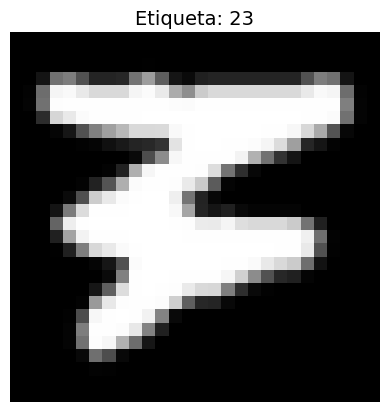

In [ ]:
idx = 0

imagen = X_train[idx].reshape(28, 28)

plt.imshow(imagen, cmap="gray")
plt.title(f"Etiqueta: {y_train[idx]}")
plt.axis("off")
plt.show()

Visualizando un grid de las primeras 25 imágenes de X_train:

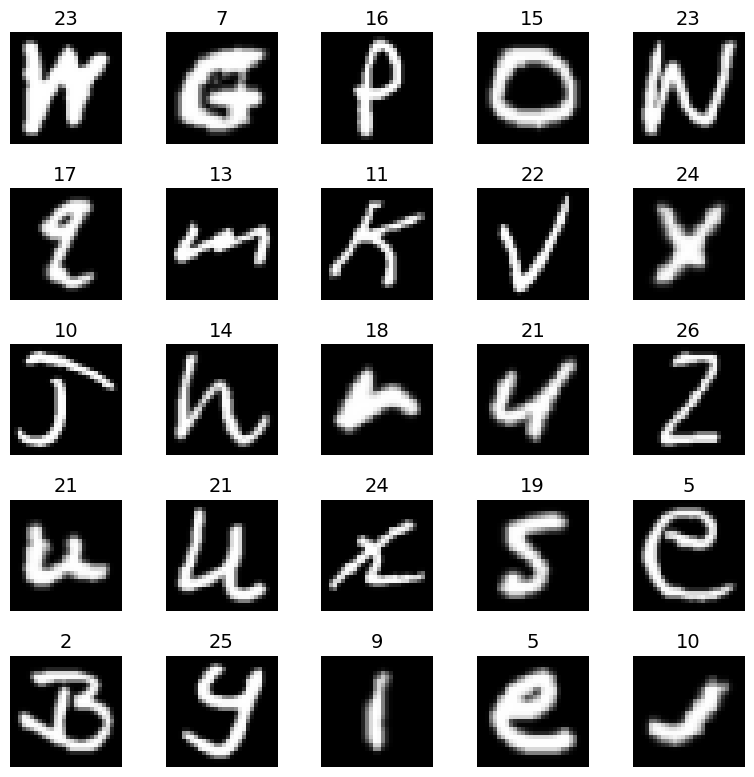

In [ ]:
filas, columnas = 5, 5
fig, axes = plt.subplots(filas, columnas, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    imagen = X_train[i].reshape(28, 28).T
    etiqueta = y_train[i]

    ax.imshow(imagen, cmap="gray")
    ax.set_title(str(etiqueta))
    ax.axis("off")

plt.tight_layout()
plt.show()

**Subset: Dividiendo la data para poder realizar los algoritmos de reducción de dimensionalidad**

In [ ]:
from sklearn.model_selection import train_test_split
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train, train_size=10000, stratify=y_train, random_state=42
)

In [ ]:
print(X_sub.shape)
print(y_sub)
print(y_sub.shape)

(10000, 784)
[ 7  6 10 ... 14 25  1]
(10000,)


**Frecuencia de las letras en la data completa.**

Validación de las etiquetas.

In [ ]:
frecuencias_letras = train_df.iloc[:, 0].value_counts().sort_index()
frecuencias_letras

,count
0,
1,3396
2,3396
3,3419
4,3398
5,3437
6,3394
7,3385
8,3424
9,3428


**Frecuencia de las letras en el subset de la data.**

Validación de las etiquetas.

In [ ]:
frecuencias_letras_sub = pd.Series(y_sub).value_counts().sort_index()
print(frecuencias_letras_sub)

1     382
2     382
3     385
4     383
5     387
6     382
7     381
8     386
9     386
10    383
11    387
12    385
13    383
14    379
15    384
16    386
17    387
18    385
19    382
20    387
21    385
22    385
23    386
24    387
25    389
26    386
Name: count, dtype: int64


## **Normalizando la data con MinMaxScaler**

Normalización (min–max): reescala cada característica a un rango fijo, por defecto
[0,1]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

X_sub_es = scaler.fit_transform(X_sub.astype(np.float32))

print("Train normalized:", X_sub_es.shape, X_sub_es.dtype)

Train normalized: (10000, 784) float32


In [ ]:
X_sub_es

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Confirmando que no se tengan valores negativos:

In [ ]:
print("Valor mínimo:", X_sub_es.min())
print("Valor máximo:", X_sub_es.max())

Valor mínimo: 0.0
Valor máximo: 1.0


# **PCA**

Método de reducción de dimensionalidad que a menudo se utiliza para reducir la dimensionalidad de grandes conjuntos de datos , transformando un conjunto grande de variables en uno más pequeño que aún contiene la mayor parte de la información del conjunto grande.

Según documentación de TSNE: It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.

Seleccionando el número de componentes: Instead of specifying the number of principal components you want to
preserve, you can set n_components to be a float between 0.0 and 1.0,
indicating the ratio of variance you wish to preserve:
pca = PCA(n_components=0.95)

In [ ]:
pca_95d = PCA(n_components=0.95, random_state=42)
X_pca_95d = pca_95d.fit_transform(X_sub_es)

In [ ]:

# Mostrar la varianza explicada por cada componente
print("Varianza explicada por cada componente:", pca_95d.explained_variance_ratio_)
print("Varianza total explicada:", pca_95d.explained_variance_ratio_.sum())


Varianza explicada por cada componente: [0.09321647 0.0669199  0.05809068 0.04643325 0.04483315 0.04036736
 0.03582078 0.03463059 0.0303663  0.02796383 0.02361509 0.02149129
 0.02009634 0.01965689 0.01820774 0.01620221 0.01530061 0.0149523
 0.013943   0.01367404 0.0134705  0.01151406 0.01118842 0.01067105
 0.0101058  0.00966761 0.00911745 0.00821745 0.00797248 0.00747787
 0.00685692 0.00664945 0.0064601  0.00618793 0.00605442 0.00576864
 0.00558039 0.00551916 0.00534173 0.00506409 0.00492811 0.00477017
 0.00452347 0.00426798 0.00414701 0.00385133 0.00369329 0.00358685
 0.00344374 0.00320888 0.00315179 0.00300922 0.00298044 0.00286164
 0.00281899 0.00276351 0.00269293 0.00264523 0.00252363 0.00249424
 0.00240403 0.00239381 0.00230569 0.0022387  0.00218297 0.00215733
 0.00188408 0.00184706 0.00179898 0.001778   0.00173638 0.00166854
 0.00163339 0.0015698  0.00156531 0.00150744 0.0014897  0.00145901
 0.0013748  0.00135804 0.00131892 0.00128737 0.00126599 0.00125562
 0.00121589 0.00120445 

In [ ]:
pca_95d.n_components_

np.int64(113)

Comprobando las dimensiones también con la gráfica del codo:

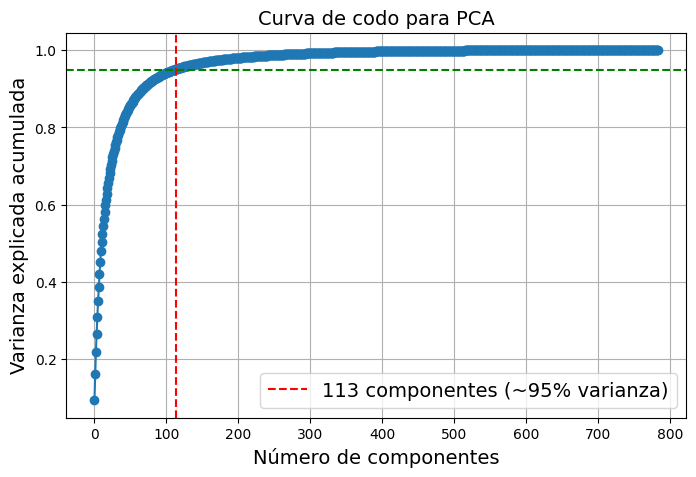

In [ ]:
# Ajustar PCA a todos los datos
pca = PCA().fit(X_sub_es)  # no le paso n_components para que calcule todos

# Calcular la varianza acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(varianza_acumulada, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Curva de codo para PCA')
plt.grid(True)

# Marcar un punto donde la varianza supere 95%
dim_95 = np.argmax(varianza_acumulada >= 0.95) + 1
plt.axvline(dim_95, color='r', linestyle='--', label=f'{dim_95} componentes (~95% varianza)')
plt.axhline(0.95, color='g', linestyle='--')

plt.legend()
plt.show()

Comprobando como finalizaron las imágenes después de PCA:

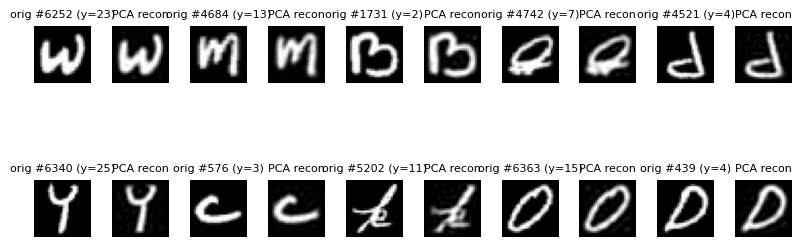

In [ ]:
X_base = X_sub_es
y_base = y_sub
rng = np.random.RandomState(42)
n = 10
idx = rng.choice(len(X_base), size=n, replace=False)

# Reconstrucción EXACTA de esas mismas filas
X_rec = pca_95d.inverse_transform(X_pca_95d[idx])
X_rec = np.clip(X_rec, 0.0, 1.0)

per_row = 5
rows = int(np.ceil(n / per_row))
cols = 2 * per_row
fig, axes = plt.subplots(rows, cols, figsize=(cols*0.8, rows*2.0))
axes = np.atleast_2d(axes)

for ax in axes.ravel():
    ax.axis("off")

fs = 8

for j, i in enumerate(idx):
    r = j // per_row
    c = (j % per_row) * 2

    # original
    ax = axes[r, c]
    ax.imshow(X_base[i].reshape(28,28).T, cmap="gray")
    ax.set_title(f"orig #{i} (y={y_base[i]})", fontsize=fs)
    ax.axis("off")

    # reconstrucción PCA
    ax = axes[r, c+1]
    ax.imshow(X_rec[j].reshape(28,28).T, cmap="gray")
    ax.set_title("PCA recon", fontsize=fs)
    ax.axis("off")

plt.tight_layout()
plt.show()

# **t-SNE**

t-SNE (t-distributed Stochastic Neighbor Embedding) es un algoritmo de aprendizaje automático utilizado para la visualización de datos de alta dimensionalidad. Su principal función es reducir la dimensionalidad de los datos a dos o tres dimensiones para facilitar la exploración y el análisis visual. t-SNE es una técnica no lineal, lo que significa que puede capturar relaciones complejas entre los datos que no serían evidentes con métodos lineales como el PCA.

In [ ]:
tsne = TSNE(
    n_components=2,        # Nº de dimensiones de salida
    learning_rate="auto",  # Tasa de aprendizaje
    perplexity=30,         # Equilibrio local/global | Número de vecinos
    random_state=42,       # Reproducibilidad
    max_iter=1000          # Iteraciones
)
sub_tsne = tsne.fit_transform(X_pca_95d)

In [ ]:
df_sub_tsne = pd.DataFrame({
    'Dim1': sub_tsne[:,0],
    'Dim2': sub_tsne[:,1],
    'Label': y_sub
})

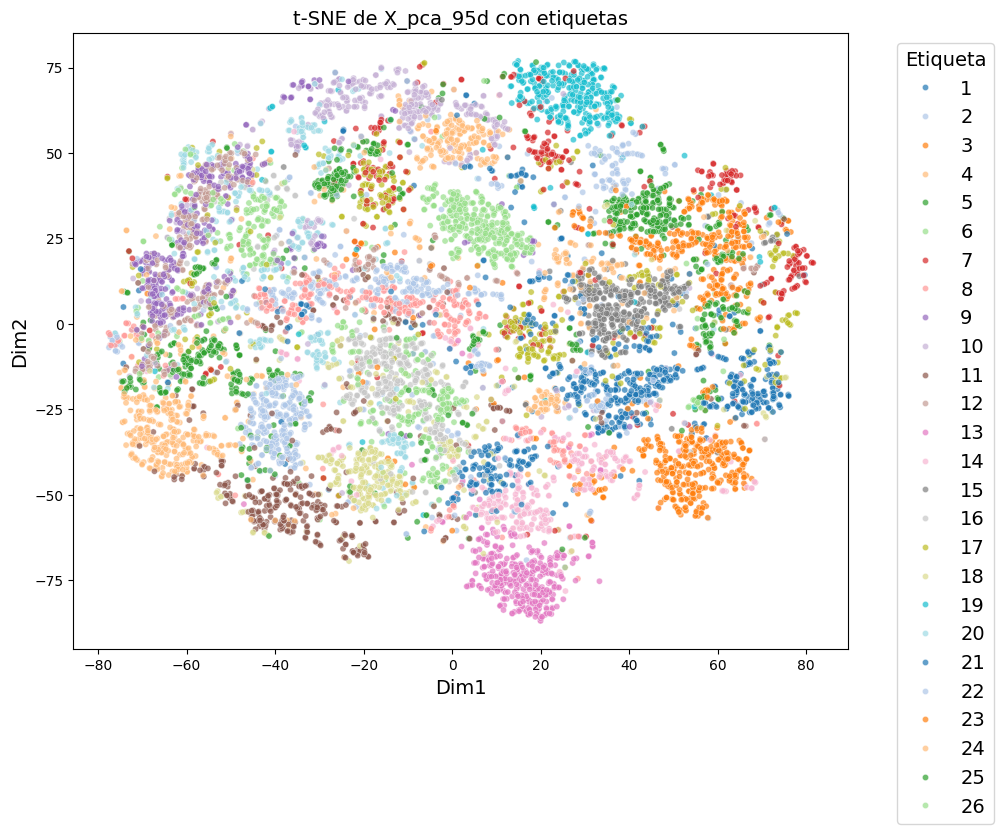

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_sub_tsne,
    x='Dim1',
    y='Dim2',
    hue='Label',           # Agrupa por etiqueta
    palette='tab20',       # Paleta de colores (se repetirá si >20)
    s=20,                  # Tamaño de puntos
    alpha=0.7,
    legend='full'
)

plt.title("t-SNE de X_pca_95d con etiquetas")
plt.legend(title="Etiqueta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



*   Cada punto representa una imágen en el dataset y cada color es una clase/label a la que esta corresponde.
*   Los puntos cercanos son imágenes similares en su composición.
* Colores mezclados son imágenes con características visuales similares.



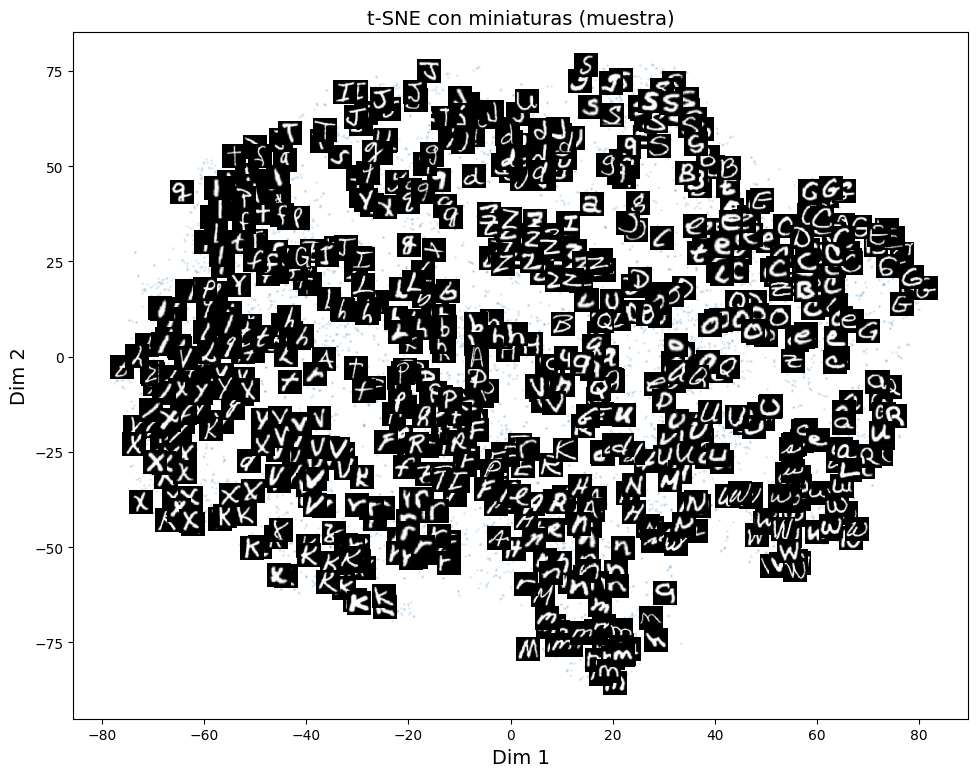

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_tsne_thumbnails(tsne_xy, X, sample=800, zoom=0.5, seed=42):
    """
    tsne_xy: array (n_muestras, 2) -> resultado de TSNE.fit_transform(...)
    X      : array (n_muestras, 784) -> imágenes en fila, idealmente en [0,1]
    sample : cuántas miniaturas poner (submuestreo para no saturar)
    zoom   : tamaño de cada miniatura
    """
    n = len(X)
    rng = np.random.RandomState(seed)
    k = min(sample, n)
    idx = rng.choice(n, size=k, replace=False)

    fig, ax = plt.subplots(figsize=(10, 8))

    # nube de fondo (puntos muy pequeños y transparentes)
    ax.scatter(tsne_xy[:, 0], tsne_xy[:, 1], s=1, alpha=0.1)

    for i in idx:
        # reconstruir la imagen 28x28 y orientar
        img = X[i].reshape(28, 28).T

        im = OffsetImage(img, zoom=zoom, cmap='gray')
        ab = AnnotationBbox(im, (tsne_xy[i, 0], tsne_xy[i, 1]),
                            frameon=False, pad=0.0)
        ax.add_artist(ab)

    ax.set_title("t-SNE con miniaturas (muestra)")
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

plot_tsne_thumbnails(sub_tsne, X_sub_es, sample=800, zoom=0.6)

## **Modelos de aprendizaje NO SUPERVISADO**



**K-Means t-sne**

Es un algoritmo no supervisado que elige k centros (centroides) iniciales, asigna cada punto al centro más cercano, recalcula los centroides, repite hasta que las asignaciones no cambien mucho, el resultado son k grupos que intentan minimizar la distancia dentro del grupo y maximizar la distancia entre grupos.

1. Iterar valores de K

In [ ]:
k_valores = range(2, 27)
silhouette_scores = []

for i in k_valores:
  kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
  kmeans.fit(sub_tsne)
  labels = kmeans.predict(sub_tsne)
  score = silhouette_score(sub_tsne, labels)
  silhouette_scores.append(score)

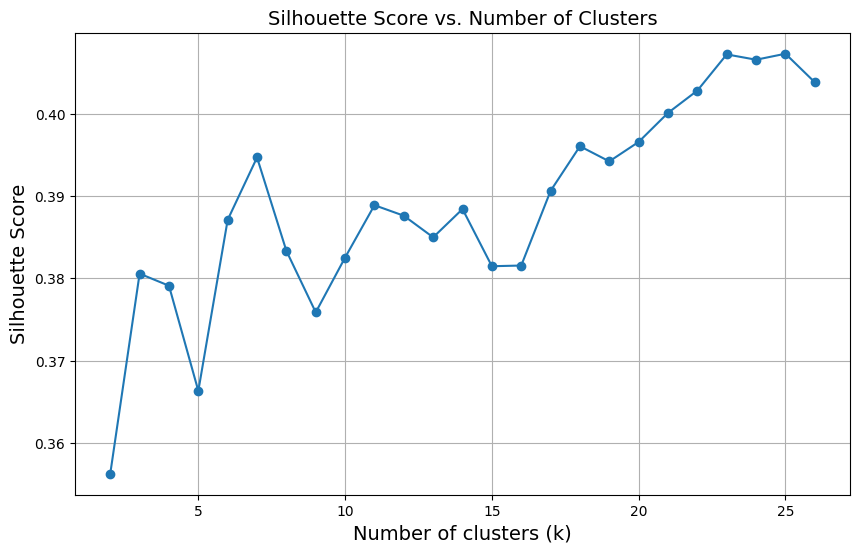

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_valores, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

Hay solapamiento entre clusteres considerando que el máximo valor de Silhouette Score es de 0.41

A pesar de la distribución de EMNIST (26 letras) el gráfico indica que 25 clusteres generan una mejor separación.

In [ ]:
k1 = 25
kmeans_25 = KMeans(n_clusters=25, random_state=42, n_init=10)
kmeans_25.fit(sub_tsne)
labels_25 = kmeans_25.labels_

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print("Silhouette:",          silhouette_score(sub_tsne, labels_25))
print("Calinski-Harabasz:",   calinski_harabasz_score(sub_tsne, labels_25))
print("Davies-Bouldin:",      davies_bouldin_score(sub_tsne, labels_25))

Silhouette: 0.4073039
Calinski-Harabasz: 11655.497
Davies-Bouldin: 0.7397938923273748


Silhouette = 0.4073 → separación moderada. Solapamiento entre clústeres ( >0.5 es una buena separación).

Davies–Bouldin = 0.7398 → Se puede mejorar separación, preferible que el valor sea por debajo de 0.6

Número de clusters: 25
Número de colores usados: 25

Cluster 0: color #1f77b4 | muestras = 430
Cluster 1: color #aec7e8 | muestras = 286
Cluster 2: color #ff7f0e | muestras = 438
Cluster 3: color #ffbb78 | muestras = 422
Cluster 4: color #2ca02c | muestras = 451
Cluster 5: color #98df8a | muestras = 362
Cluster 6: color #d62728 | muestras = 479
Cluster 7: color #ff9896 | muestras = 462
Cluster 8: color #9467bd | muestras = 352
Cluster 9: color #c5b0d5 | muestras = 253
Cluster 10: color #8c564b | muestras = 489
Cluster 11: color #c49c94 | muestras = 498
Cluster 12: color #e377c2 | muestras = 390
Cluster 13: color #f7b6d2 | muestras = 414
Cluster 14: color #7f7f7f | muestras = 403
Cluster 15: color #c7c7c7 | muestras = 335
Cluster 16: color #bcbd22 | muestras = 529
Cluster 17: color #dbdb8d | muestras = 352
Cluster 18: color #17becf | muestras = 319
Cluster 19: color #9edae5 | muestras = 402
Cluster 20: color #393b79 | muestras = 382
Cluster 21: color #5254a3 | muestras = 404
Cluster 22:

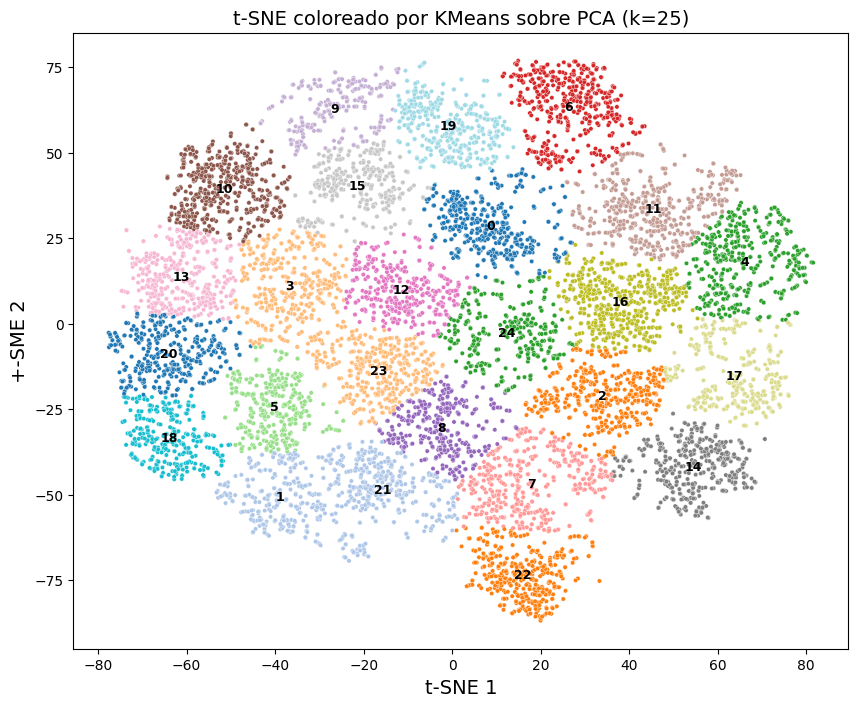

Silhouette score: 0.4073039


In [ ]:
from matplotlib.colors import to_hex

plt.figure(figsize=(10, 8))
sns.scatterplot(x=sub_tsne[:,0], y=sub_tsne[:,1],
hue=labels_25, palette='tab20', s=10, legend=None)
for c in np.unique(labels_25):
    x, y = sub_tsne[labels_25 == c].mean(0)
    plt.text(x, y, str(c), ha='center', va='center', fontsize=9, weight='bold')
plt.title(f"t-SNE coloreado por KMeans sobre PCA (k={k1})")
plt.xlabel("t-SNE 1")
plt.ylabel("+-SME 2")
# clusters presentes y tamaños
uniq, counts = np.unique(labels_25, return_counts=True)
k1 = len(uniq)

# misma paleta que usaste en el scatter
palette25 = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 5)
hex_colors = [to_hex(c) for c in palette25]

print(f"Número de clusters: {k1}")
print(f"Número de colores usados: {len(set(hex_colors))}\n")

for cid, n, col in zip(uniq, counts, hex_colors):
    print(f"Cluster {cid}: color {col} | muestras = {n}")
plt.show()

print("Silhouette score:", silhouette_score(sub_tsne, labels_25))

In [ ]:
k2 = 26
kmeans_26 = KMeans(n_clusters=26, random_state=42, n_init=10)
kmeans_26.fit(sub_tsne)
labels_26 = kmeans_26.labels_

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print("Silhouette:",          silhouette_score(sub_tsne, labels_26))
print("Calinski-Harabasz:",   calinski_harabasz_score(sub_tsne, labels_26))
print("Davies-Bouldin:",      davies_bouldin_score(sub_tsne, labels_26))

Silhouette: 0.40383202
Calinski-Harabasz: 11709.932
Davies-Bouldin: 0.7520962053706968


Silhouette = 0.4073 vs 0.4038 → Mejores resultados con k = 25

Davies–Bouldin = 0.7398 vs 0.7521 → Mejores resultados con k = 25

Número de clusters: 26
Número de colores usados: 26

Cluster 0: color #1f77b4 | muestras = 519
Cluster 1: color #aec7e8 | muestras = 400
Cluster 2: color #ff7f0e | muestras = 253
Cluster 3: color #ffbb78 | muestras = 466
Cluster 4: color #2ca02c | muestras = 405
Cluster 5: color #98df8a | muestras = 414
Cluster 6: color #d62728 | muestras = 403
Cluster 7: color #ff9896 | muestras = 402
Cluster 8: color #9467bd | muestras = 296
Cluster 9: color #c5b0d5 | muestras = 325
Cluster 10: color #8c564b | muestras = 322
Cluster 11: color #c49c94 | muestras = 469
Cluster 12: color #e377c2 | muestras = 422
Cluster 13: color #f7b6d2 | muestras = 320
Cluster 14: color #7f7f7f | muestras = 292
Cluster 15: color #c7c7c7 | muestras = 412
Cluster 16: color #bcbd22 | muestras = 328
Cluster 17: color #dbdb8d | muestras = 364
Cluster 18: color #17becf | muestras = 400
Cluster 19: color #9edae5 | muestras = 368
Cluster 20: color #393b79 | muestras = 445
Cluster 21: color #5254a3 | muestras = 399
Cluster 22:

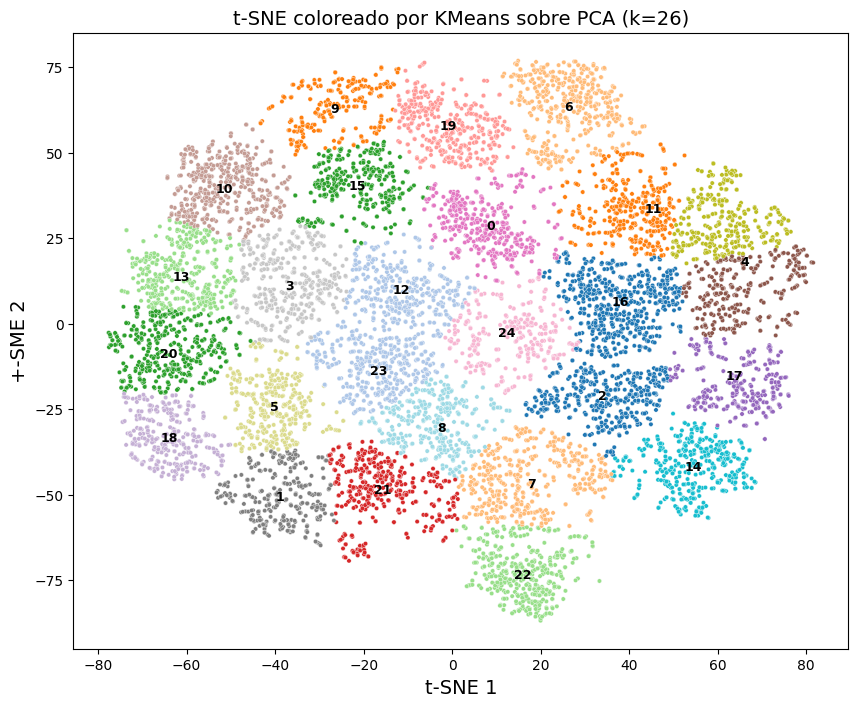

Silhouette score: 0.40383202


In [ ]:
from matplotlib.colors import to_hex

plt.figure(figsize=(10, 8))
sns.scatterplot(x=sub_tsne[:,0], y=sub_tsne[:,1],
hue=labels_26, palette='tab20', s=10, legend=None)
for c in np.unique(labels_25):
    x, y = sub_tsne[labels_25 == c].mean(0)
    plt.text(x, y, str(c), ha='center', va='center', fontsize=9, weight='bold')
plt.title(f"t-SNE coloreado por KMeans sobre PCA (k={k2})")
plt.xlabel("t-SNE 1")
plt.ylabel("+-SME 2")
# clusters presentes y tamaños
uniq, counts = np.unique(labels_26, return_counts=True)
k2 = len(uniq)

# misma paleta que usaste en el scatter
palette26 = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 6)
hex_colors = [to_hex(c) for c in palette26]

print(f"Número de clusters: {k2}")
print(f"Número de colores usados: {len(set(hex_colors))}\n")

for cid, n, col in zip(uniq, counts, hex_colors):
    print(f"Cluster {cid}: color {col} | muestras = {n}")
plt.show()

print("Silhouette score:", silhouette_score(sub_tsne, labels_26))

Comprobando con gráfica de Silhouette

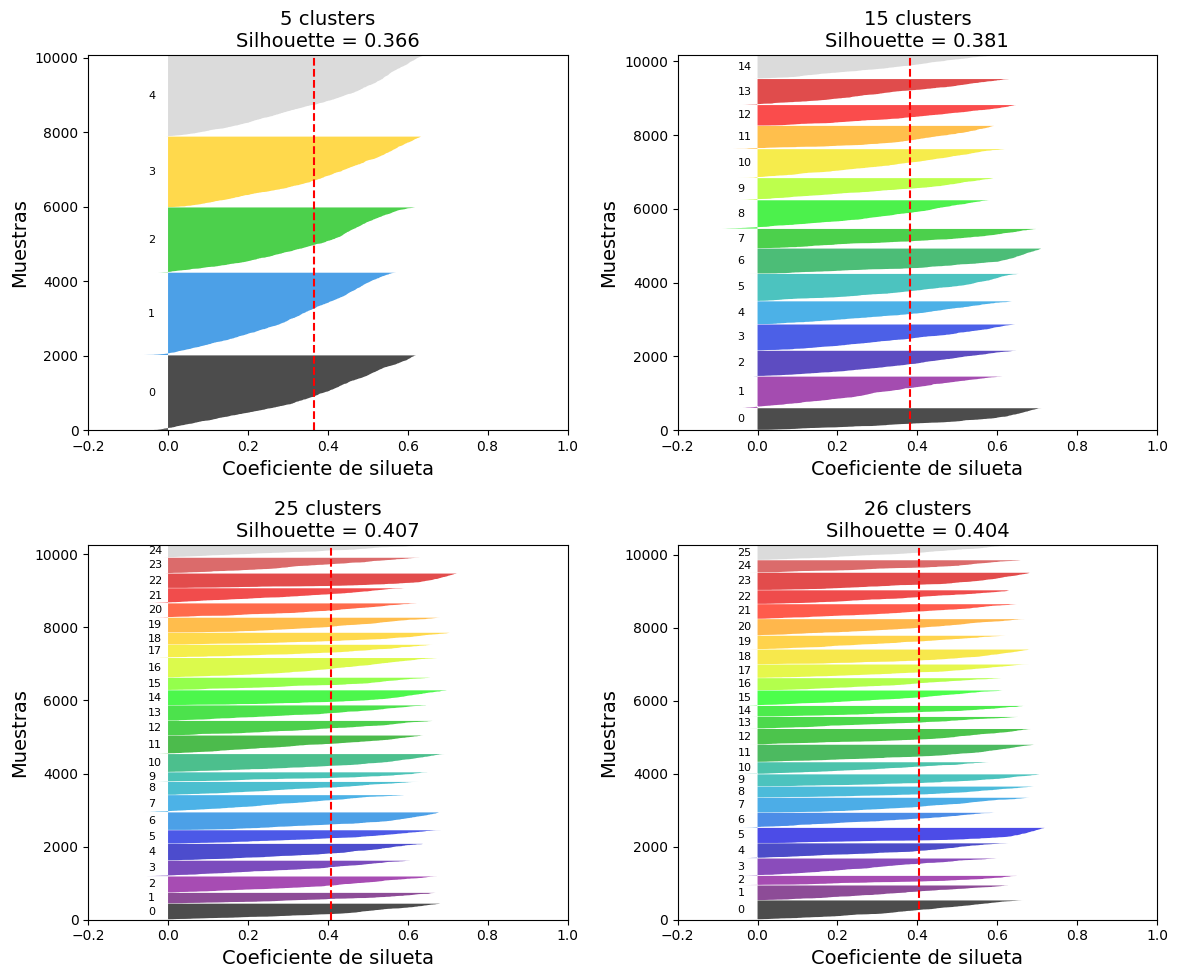

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

k_values = [5, 15, 25, 26]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, k in zip(axes, k_values):
    # Clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(sub_tsne)

    # Silhouette
    s_avg = silhouette_score(sub_tsne, labels)
    s_samples = silhouette_samples(sub_tsne, labels)

    # Plot de silueta por cluster
    y_lower = 10
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, k))
    for i, col in zip(range(k), colors):
        vals = np.sort(s_samples[labels == i])
        size_i = vals.shape[0]
        y_upper = y_lower + size_i

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                         facecolor=col, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_i, str(i), va='center', fontsize=8)
        y_lower = y_upper + 10  # espacio entre clusters

    # Detalles del panel
    ax.axvline(x=s_avg, color="red", linestyle="--", linewidth=1.5)
    ax.set_xlim([-0.2, 1.0])
    ax.set_ylim([0, y_lower])
    ax.set_title(f"{k} clusters\nSilhouette = {s_avg:.3f}")
    ax.set_xlabel("Coeficiente de silueta")
    ax.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

k=25 (Silhouette = 0.407): mayor promedio.

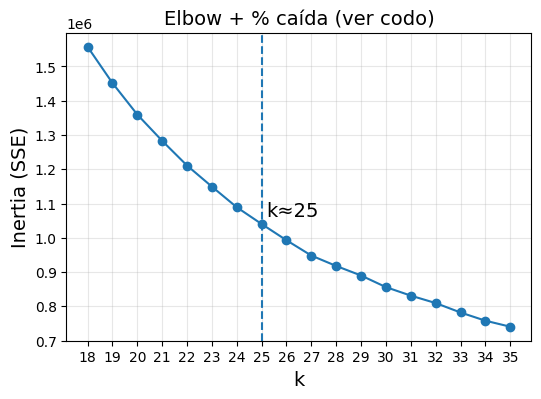

k=19  caída relativa= 6.79%
k=20  caída relativa= 6.34%
k=21  caída relativa= 5.64%
k=22  caída relativa= 5.62%
k=23  caída relativa= 5.08%
k=24  caída relativa= 5.24%
k=25  caída relativa= 4.50%
k=26  caída relativa= 4.56%
k=27  caída relativa= 4.50%
k=28  caída relativa= 3.20%
k=29  caída relativa= 3.04%
k=30  caída relativa= 3.80%
k=31  caída relativa= 2.90%
k=32  caída relativa= 2.61%
k=33  caída relativa= 3.40%
k=34  caída relativa= 3.06%
k=35  caída relativa= 2.32%


In [ ]:
X_used = sub_tsne
Ks = list(range(18, 36))
inertias = []

for K in Ks:
    km = KMeans(n_clusters=K, n_init=20, random_state=0).fit(X_used)
    inertias.append(km.inertia_)

inertias = np.array(inertias)
rel_drop = -np.diff(inertias) / inertias[:-1]  # % de mejora al pasar de k-1 -> k
mid_Ks = Ks[1:]

fig = plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.xticks(Ks)
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow + % caída (ver codo)")
plt.grid(True, alpha=0.3)

threshold = 0.05
candidates = [k for k, rd in zip(mid_Ks, rel_drop) if rd < threshold]
if candidates:
    k_elbow = candidates[0]
    plt.axvline(k_elbow, linestyle="--")
    plt.text(k_elbow+0.2, inertias[Ks.index(k_elbow)]*1.02, f"k≈{k_elbow}")

plt.show()

for k, rd in zip(mid_Ks, rel_drop):
    print(f"k={k:2d}  caída relativa={rd*100:5.2f}%")

Después de 25 las caídas se aplanan y la curva se suaviza.

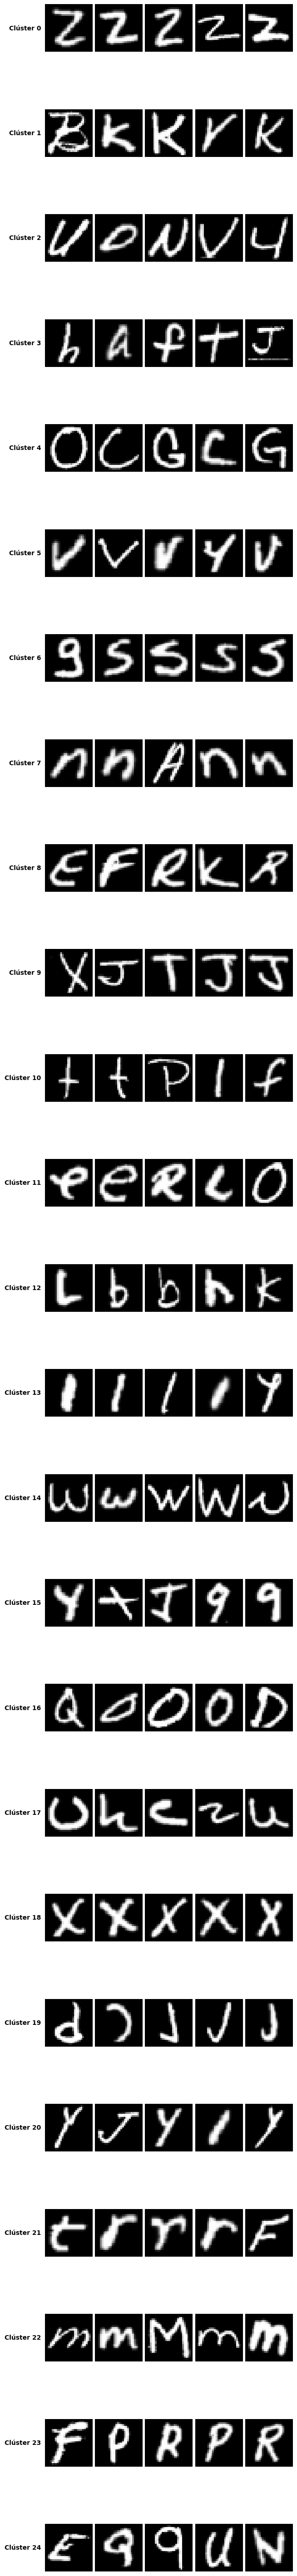

In [ ]:
n = 5          # imágenes por clúster (columnas)
k = 25         # número de clústeres (filas)

sample_size = 5000
np.random.seed(42)
idx = np.random.choice(len(X_sub_es), sample_size, replace=False)

plt.figure(figsize=(7, 3 * k))

for cluster_id in range(k):
    cluster_all = np.where(labels_25 == cluster_id)[0]
    cluster_indices = np.intersect1d(cluster_all, idx)

    num_samples_to_show = min(n, len(cluster_indices))
    if num_samples_to_show == 0:
        continue

    show_idx = np.random.choice(cluster_indices, size=num_samples_to_show, replace=False)

    for i, original_idx in enumerate(show_idx):
        pos = cluster_id * n + i + 1
        ax = plt.subplot(k, n, pos)

        img = X_sub_es[original_idx].reshape(28, 28).T
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        if i == 0:
            ax.text(
                -0.08, 0.5,
                f"Clúster {cluster_id}",
                transform=ax.transAxes,
                ha="right", va="center",
                fontsize=10, fontweight="bold",
                clip_on=False
            )

plt.subplots_adjust(left=0.12, wspace=0.05, hspace=0.05)
plt.show()